# Airline Passenger Prediction
## Keras LSTM
- Time series prediction as a NN regression
- How to frame time series prediction with time lag and create a NN model for it

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'

from keras.models import Sequential
from keras.layers import Dense

In [12]:
ls

TSLA-test.csv                         airline.ipynb
TSLA-train.csv                        international-airline-passengers.csv
Tesla.ipynb


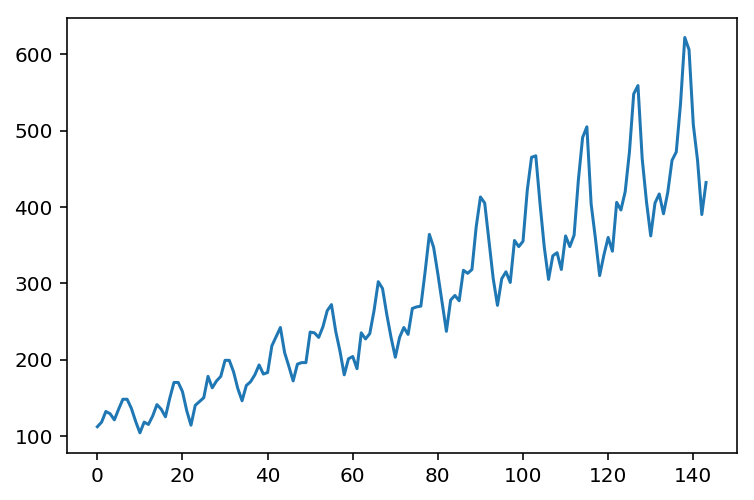

In [13]:
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

Plot shows a general upward trend.
Periodicity in the dataset that probably corresponds with the summer holiday period


## MLP Regression
We want to phrase the time series prediction problem as a regression problem.

Given # passengers (in thousands this month), what is the number of passengers next month

_Overview_: <br/>
_Write a simple function to convert single column of data into a two-column dataset. The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted._

In [15]:
# fix random seed 
np.random.seed(7)

In [18]:
# convert integers to floats, which are more suitable for NN modeling
dataframe = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

In [21]:
type(dataset[0][0])

numpy.float32

In [26]:
# cross val with train/test sets

train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

100 44


The function to create the new dataset will take two arguments:
1. _dataset_ : a NumPy array 
2. _lookback_ : number of previous time steps to use as input variables to predict the next time period

The default value for look_back will be 1. 

The resultant dataset will have 
1. X : the number of passengers at time (t)
2. Y : the number of passengers at the next time (t + lookback)

In [27]:
def create_lag( dataset, look_back=1 ):
    dataX, dataY = [], []
    for i in range( len(dataset) - look_back - 1 ):
        a = dataset[ i : (i + look_back), 0 ]
        dataX.append(a)
        dataY.append(dataset[ i + look_back, 0 ])
    return np.array(dataX), np.array(dataY)

In [29]:
X,Y = create_lag( dataset )

In [45]:
frame = pd.DataFrame( np.column_stack([X, Y]), columns=['X', 'Y']  )
frame.head()

,X,Y
0,112.0,118.0
1,118.0,132.0
2,132.0,129.0
3,129.0,121.0
4,121.0,135.0


- Prepare train and test datasets

In [59]:
look_back = 1
trainX, trainY = create_lag(train, look_back)
testX, testY = create_lag(test, look_back)

In [63]:
frame = pd.DataFrame( np.column_stack( [trainX, trainY]), columns=['trainX', 'trainY'] )
frame.head()

,trainX,trainY
0,112.0,118.0
1,118.0,132.0
2,132.0,129.0
3,129.0,121.0
4,121.0,135.0


In [64]:
frame = pd.DataFrame( np.column_stack( [testX, testY]), columns=['testX', 'testY'] )
frame.head()

,testX,testY
0,355.0,422.0
1,422.0,465.0
2,465.0,467.0
3,467.0,404.0
4,404.0,347.0


### Multilayer Perceptron 
- Simple Network with 1 input, 1 hidden layer, 8 neurons, and an output layer
- Fit using MSE

In [47]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
 - 0s - loss: 49777.3983
Epoch 2/200
 - 0s - loss: 43677.5750
Epoch 3/200
 - 0s - loss: 37310.7540
Epoch 4/200
 - 0s - loss: 30775.4784
Epoch 5/200
 - 0s - loss: 24211.4780
Epoch 6/200
 - 0s - loss: 18120.8110
Epoch 7/200
 - 0s - loss: 12868.7078
Epoch 8/200
 - 0s - loss: 8514.9265
Epoch 9/200
 - 0s - loss: 5347.8609
Epoch 10/200
 - 0s - loss: 3203.3661
Epoch 11/200
 - 0s - loss: 1909.8091
Epoch 12/200
 - 0s - loss: 1176.4366
Epoch 13/200
 - 0s - loss: 826.5096
Epoch 14/200
 - 0s - loss: 659.3309
Epoch 15/200
 - 0s - loss: 597.2369
Epoch 16/200
 - 0s - loss: 570.9645
Epoch 17/200
 - 0s - loss: 561.4623
Epoch 18/200
 - 0s - loss: 561.6570
Epoch 19/200
 - 0s - loss: 559.3014
Epoch 20/200
 - 0s - loss: 562.8311
Epoch 21/200
 - 0s - loss: 561.3278
Epoch 22/200
 - 0s - loss: 561.4553
Epoch 23/200
 - 0s - loss: 562.3898
Epoch 24/200
 - 0s - loss: 560.1166
Epoch 25/200
 - 0s - loss: 560.1949
Epoch 26/200
 - 0s - loss: 561.9665
Epoch 27/200
 - 0s - loss: 562.0647
Epoch 28/200
 - 0s

In [49]:
import math
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 554.93 MSE (23.56 RMSE)
Test Score: 2504.66 MSE (50.05 RMSE)


In [55]:
# average error of 23.6 passengers (in thousands) on the training dataset
# 50 passengers (in thousands) on the test dataset.

The predictions must be shifted back so that they align with the original dataset's x-axis

Original in blue, train dataset predictions in green, test dataset predictions in red

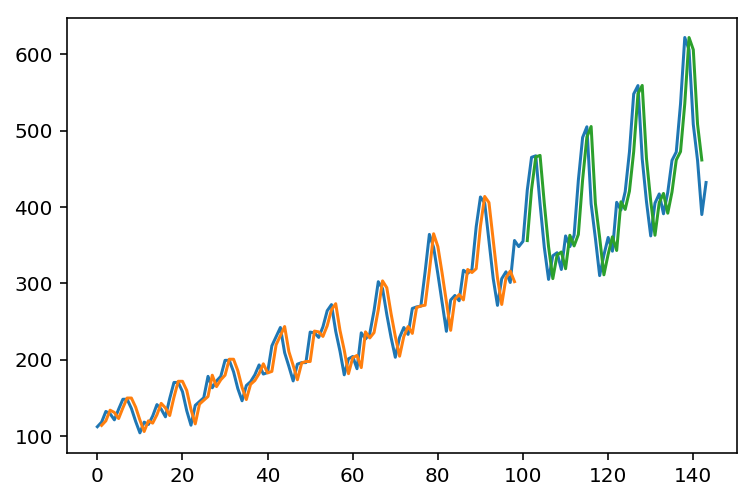

In [51]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Window Method
- Phrase the problem so that multiple recent time steps can be used to make the prediction for the next time step
- This is called the window method
    - window size is a parameter that can be tuned
    
For example, set input as t-2, t-1, and t with an output of t+1

In [54]:
# Use create_lag function with look_back argument of 3
ntrainX, ntrainY = create_lag(train, look_back=3)
ntestX, ntestY = create_lag(test, look_back=3)

In [70]:
ntrainX[0]

array([112., 118., 132.], dtype=float32)

Network size should be increased to handle the additional information.
- First hidden layer increased to 14 neurons
- Additional seocnd layer of 8 neurons

Epochs increased to 400

In [71]:
model = Sequential()
model.add(Dense(12, input_dim=3, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [72]:
model.fit(ntrainX, ntrainY, epochs=400, batch_size=2, verbose=2)

Epoch 1/400
 - 0s - loss: 95526.3910
Epoch 2/400
 - 0s - loss: 50662.9441
Epoch 3/400
 - 0s - loss: 36549.1938
Epoch 4/400
 - 0s - loss: 24667.7349
Epoch 5/400
 - 0s - loss: 12624.6552
Epoch 6/400
 - 0s - loss: 4707.3015
Epoch 7/400
 - 0s - loss: 1671.4660
Epoch 8/400
 - 0s - loss: 1074.5510
Epoch 9/400
 - 0s - loss: 1027.4936
Epoch 10/400
 - 0s - loss: 1020.2705
Epoch 11/400
 - 0s - loss: 1015.3426
Epoch 12/400
 - 0s - loss: 1004.6532
Epoch 13/400
 - 0s - loss: 1016.5961
Epoch 14/400
 - 0s - loss: 1005.9835
Epoch 15/400
 - 0s - loss: 1008.4936
Epoch 16/400
 - 0s - loss: 988.5564
Epoch 17/400
 - 0s - loss: 983.3164
Epoch 18/400
 - 0s - loss: 986.2019
Epoch 19/400
 - 0s - loss: 975.2351
Epoch 20/400
 - 0s - loss: 972.3536
Epoch 21/400
 - 0s - loss: 971.8468
Epoch 22/400
 - 0s - loss: 976.7838
Epoch 23/400
 - 0s - loss: 959.4808
Epoch 24/400
 - 0s - loss: 946.4456
Epoch 25/400
 - 0s - loss: 966.2689
Epoch 26/400
 - 0s - loss: 971.4692
Epoch 27/400
 - 0s - loss: 937.5831
Epoch 28/400
 - 0

Epoch 225/400
 - 0s - loss: 519.2607
Epoch 226/400
 - 0s - loss: 557.1206
Epoch 227/400
 - 0s - loss: 545.6508
Epoch 228/400
 - 0s - loss: 536.6355
Epoch 229/400
 - 0s - loss: 532.5135
Epoch 230/400
 - 0s - loss: 545.4934
Epoch 231/400
 - 0s - loss: 534.5664
Epoch 232/400
 - 0s - loss: 522.2457
Epoch 233/400
 - 0s - loss: 550.9680
Epoch 234/400
 - 0s - loss: 542.5556
Epoch 235/400
 - 0s - loss: 535.1148
Epoch 236/400
 - 0s - loss: 567.6999
Epoch 237/400
 - 0s - loss: 555.4777
Epoch 238/400
 - 0s - loss: 526.8672
Epoch 239/400
 - 0s - loss: 556.3523
Epoch 240/400
 - 0s - loss: 537.5128
Epoch 241/400
 - 0s - loss: 539.4107
Epoch 242/400
 - 0s - loss: 538.4591
Epoch 243/400
 - 0s - loss: 532.1158
Epoch 244/400
 - 0s - loss: 563.4680
Epoch 245/400
 - 0s - loss: 522.6310
Epoch 246/400
 - 0s - loss: 546.5037
Epoch 247/400
 - 0s - loss: 536.3462
Epoch 248/400
 - 0s - loss: 536.2587
Epoch 249/400
 - 0s - loss: 573.1856
Epoch 250/400
 - 0s - loss: 551.7669
Epoch 251/400
 - 0s - loss: 533.0898
E

In [74]:
# new model performance
trainScore = model.evaluate(ntrainX, ntrainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(ntestX, ntestY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 508.73 MSE (22.55 RMSE)
Test Score: 2132.07 MSE (46.17 RMSE)


Better scores of 22.5 / 46.2 ! <br/>
If we tuned the sizes of the network and window we could probably have even better results

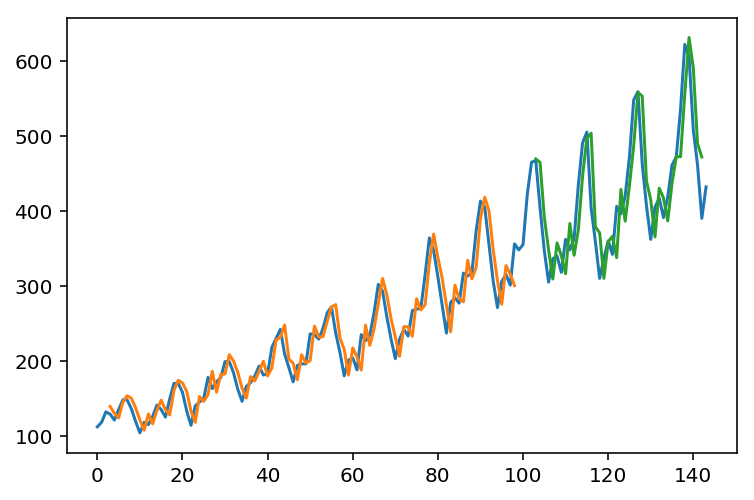

In [77]:
trainPredict = model.predict(ntrainX)
testPredict = model.predict(ntestX)
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[3:len(trainPredict)+ 3, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(3*2)+1:len(dataset)-1, :] = testPredict
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()